# Libs

In [1]:
import modCommon

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import importlib

import warnings
warnings.filterwarnings("ignore")

import matplotlib
%matplotlib inline

from timeit import default_timer as timer
from datetime import timedelta

from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

from scipy.stats import yeojohnson
from sklearn.preprocessing import PowerTransformer

import time

pd.options.display.float_format = '{:.2f}'.format

In [2]:
importlib.reload(modCommon)

<module 'modCommon' from 'c:\\Users\\Chilelli\\Documents\\MBA\\TCC\\git\\modCommon.py'>

# Testando Cenários

In [3]:
def funcLoadValidationData(
    sPath, sTarget,
    dfImportance = pd.DataFrame(), iImportance = 0, nSubSampleSize = 0, bRemoveOutliers = False, bDropNa = False):

    dfValidation = pd.read_csv(sPath).drop(['customer_unique_id', 'estado', 'month_year'], axis = 1)

    if nSubSampleSize > 0:
        dfValidation = pd.concat(
            [
                dfValidation[dfValidation.has_buy.isin([1])],
                dfValidation[dfValidation.has_buy == 0].sample(frac = nSubSampleSize)
            ]
        )

    if len(dfImportance) > 1:
        dfValidation = dfValidation[list(dfImportance[dfImportance[0] >= iImportance].index) + [sTarget]]

    if bDropNa:
        dfValidation = dfValidation.dropna(axis = 0)

    yj = PowerTransformer(copy = True, method = 'yeo-johnson', standardize = True) 
    dfValidationPower = yj.fit_transform(dfValidation[list(set(dfValidation.columns) - set(sTarget))])
    dfValidationPower = pd.DataFrame(
        dfValidationPower,
        columns = dfValidation[list(set(dfValidation.columns) - set(sTarget))].columns).set_index(dfValidation.index)
    dfValidation = dfValidationPower.join(dfValidation[sTarget])

    if bRemoveOutliers:
        dfValidation = dfValidation[
            (np.abs(
                zscore(dfValidation[list(set(dfValidation.columns) - set(sTarget))])) < 3).all(axis=1)
        ]
    else:
        for sCol in (set(dfValidation.columns) - set(sTarget)):
            Q1, Q3 = np.percentile(dfValidation[sCol], [25, 75])
            IQR = Q3 - Q1
            S = 1.5 * IQR
            iLB = Q1 - S
            iUB = Q3 + S
            dfValidation[sCol] = dfValidation[sCol].clip(iLB, iUB) # NaN nao sao substituidos pelo pd.clip()

    dfValidation = dfValidation.fillna(0)
    dfValidation[dfValidation < 0] = 0
    
    dfYValidation = dfValidation[sTarget[0]]
    if len(dfImportance) > 1:
        dfXValidation = dfValidation[list(dfImportance[dfImportance[0] >= iImportance].index)]
    else:
        dfXValidation = dfValidation.iloc[:, :-1]

    return([dfXValidation, dfYValidation])


----------------------------------
Testando modelo: has_buy
----------------------------------

Carregando bases de validacao
Tempo: Data Pre-Process 25
max_depth 2, min_samples_split 2, n_estimator 100, max_features auto, weight balanced_subsample, importance 0, remove outliers False. Runtime: 64 seg


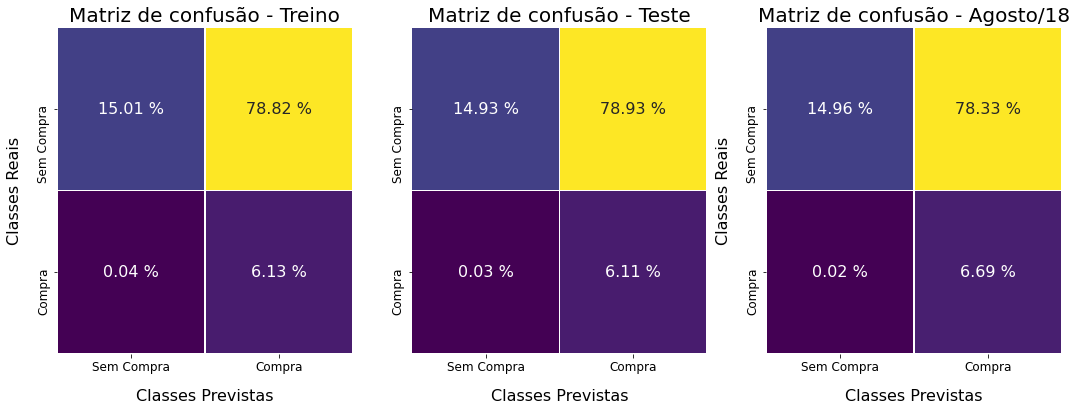

max_depth 2, min_samples_split 2, n_estimator 100, max_features auto, weight balanced, importance 0, remove outliers False. Runtime: 30 seg


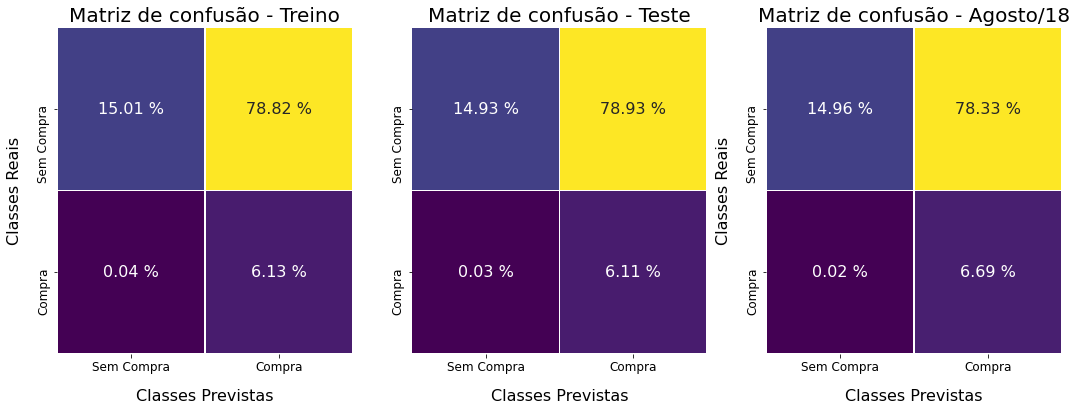

In [6]:
bRerun = False
bWriteReport = False
bLoadData = True

#dfForestImportance = dfForestImportanceNew#.drop('bienjoei_sales_soldat_ult', axis = 0).copy()

# classes de modelo e os pesos atribuidos a classe 1 (quando ocorre o evento)
dictWeightCluster = {
    'has_buy': ['balanced_subsample', 'balanced']#[[0.95]]
}

iImp = 0

sCriterion = 'gini'
siMaxDepth = [2]
siMinSampleSplit = [2]
siNEstimators = [100]
ssMaxFeatures = ['auto']

nSubSample = [0]

sObs = 'Removendo Outliers por Quartil'

iCounter = 1
##--------------------------------
# Report of the model
##--------------------------------
sReportPath = modCommon.sRootPath + 'all_models_report.xlsx'
sReportValidation = modCommon.sRootPath + 'validation_all_models_report.xlsx'

if bRerun:
    dfReport = pd.read_excel(sReportPath)
    dfReportValidation = pd.read_excel(sReportValidation)
else:
    dfReport = pd.DataFrame()
    dfReportValidation = pd.DataFrame()

#---------------------------
#---------------------------
# INICIO DO TESTE
#---------------------------
#---------------------------
for sTarget in dictWeightCluster.keys():
    print('\n----------------------------------\nTestando modelo: {}\n----------------------------------\n'.format(sTarget))

    if bLoadData:
        nStartDataPreProcess = timer()

        print('Carregando bases de validacao')
        dfXValidation, dfYValidation = funcLoadValidationData(
            sPath = modCommon.sAttValidation, sTarget = [sTarget],
            #dfImportance = dfForestImportance, iImportance = iImp, 
            bRemoveOutliers = False,
        )

    for bRemoveOut in [False]:
        
        dfX, dfY = funcLoadValidationData(
            sPath = modCommon.sAttComplete, sTarget = [sTarget],
            #dfImportance = dfForestImportance, iImportance = iImp, 
            nSubSampleSize = 0, bRemoveOutliers = bRemoveOut 
        )

        dfXTrain, dfXTest, dfYTrain, dfYTest = train_test_split(
            dfX, dfY, train_size = 0.80, random_state = modCommon.iRandomState)

        nEndDataPreProcess = timer()
        print('Tempo: Data Pre-Process {}'.format(
            timedelta(seconds = nEndDataPreProcess - nStartDataPreProcess).seconds
            )
        )
        
        for iMaxDepth in siMaxDepth:
            for iMinSampleSplit in siMinSampleSplit:
                for iNEstimators in siNEstimators:
                    for sMaxFeatures in ssMaxFeatures:
                        for iWeight in dictWeightCluster[sTarget]:

                            nStartModel = timer()

                            mRandomForest = RandomForestClassifier(
                                class_weight = iWeight,
                                #class_weight = {0:(1 - iWeight), 1:iWeight},
                                criterion = sCriterion,
                                max_depth = iMaxDepth,
                                max_features = sMaxFeatures,
                                min_samples_split = iMinSampleSplit,
                                n_estimators = iNEstimators,
                                n_jobs = -1,
                                random_state = modCommon.iRandomState,
                            ).fit(dfXTrain, dfYTrain)

                            # Treino
                            iAuc = round(roc_auc_score(dfYTrain, mRandomForest.predict_proba(dfXTrain)[:, :1], average = 'weighted'), 2)
                            dfReportLastModel = pd.DataFrame(classification_report(dfYTrain, mRandomForest.predict(dfXTrain), output_dict = True)).iloc[:3, :3].reset_index()

                            dfReportLastModel['auc'] = iAuc
                            dfReportLastModel['counter'] = iCounter
                            dfReportLastModel['model'] = sTarget
                            dfReportLastModel['step'] = "train"
                            dfReportLastModel['depth'] = iMaxDepth
                            dfReportLastModel['min_smp_split'] = iMinSampleSplit
                            dfReportLastModel['n_estimators'] = iNEstimators
                            dfReportLastModel['max_features'] = sMaxFeatures
                            dfReportLastModel['importance'] = iImp
                            dfReportLastModel['weight'] = iWeight
                            dfReportLastModel['sub_sample'] = bRemoveOut
                            dfReportLastModel['obs'] = sObs
                            dfReport = pd.concat([dfReport,dfReportLastModel])

                            #-----------------------------------------
                            # Test
                            iAuc = round(roc_auc_score(dfYTest, mRandomForest.predict_proba(dfXTest)[:, :1], average = 'weighted'), 2)
                            dfReportLastModel = pd.DataFrame(classification_report(dfYTest, mRandomForest.predict(dfXTest), output_dict = True)).iloc[:3, :3].reset_index()
                            dfReportLastModel['auc'] = iAuc
                            dfReportLastModel['counter'] = iCounter
                            dfReportLastModel['model'] = sTarget
                            dfReportLastModel['step'] = "test"
                            dfReportLastModel['depth'] = iMaxDepth
                            dfReportLastModel['min_smp_split'] = iMinSampleSplit
                            dfReportLastModel['n_estimators'] = iNEstimators
                            dfReportLastModel['max_features'] = sMaxFeatures
                            dfReportLastModel['importance'] = iImp
                            dfReportLastModel['weight'] = iWeight
                            dfReportLastModel['sub_sample'] = bRemoveOut
                            dfReportLastModel['obs'] = sObs
                            dfReport = pd.concat([dfReport,dfReportLastModel])

                            #-----------------------------------------
                            #-----------------------------------------
                            #-----------------------------------------

                            iAucValidation = round(roc_auc_score(dfYValidation, mRandomForest.predict_proba(dfXValidation)[:, :1], average = 'weighted'), 2)
                            dfReportValidationLast = pd.DataFrame(classification_report(dfYValidation, mRandomForest.predict(dfXValidation), output_dict = True)).iloc[:3, :3].reset_index()
                            dfReportValidationLast['auc'] = iAucValidation
                            dfReportValidationLast['counter'] = iCounter
                            dfReportValidationLast['model'] = sTarget
                            dfReportValidationLast['month'] = 'aug'
                            dfReportValidationLast['depth'] = iMaxDepth
                            dfReportValidationLast['min_smp_split'] = iMinSampleSplit
                            dfReportValidationLast['n_estimators'] = iNEstimators
                            dfReportValidationLast['max_features'] = sMaxFeatures
                            dfReportValidationLast['importance'] = iImp
                            dfReportValidationLast['weight'] = iWeight
                            dfReportValidationLast['sub_sample'] = bRemoveOut
                            dfReportValidationLast['obs'] = sObs
                            dfReportValidation = pd.concat([dfReportValidation, dfReportValidationLast])

                            iCounter += 1

                            nEndModel = timer()
                            print('max_depth {}, min_samples_split {}, n_estimator {}, max_features {}, weight {}, importance {}, remove outliers {}. Runtime: {} seg'.format(
                                iMaxDepth, iMinSampleSplit, iNEstimators, sMaxFeatures, iWeight, iImp, bRemoveOut,
                                timedelta(seconds = nEndModel - nStartModel).seconds
                                )
                            )

                            if bWriteReport:
                                dfReport.to_excel(sReportPath, index = False)
                                dfReportValidation.to_excel(sReportValidation, index = False)
                                
                            dfConfusionTrain = (confusion_matrix(dfYTrain, mRandomForest.predict(dfXTrain), normalize = 'all') * 100)
                            dfConfusionTest = (confusion_matrix(dfYTest, mRandomForest.predict(dfXTest), normalize = 'all') * 100)

                            fig, axs = plt.subplots(1, 3, figsize=(18, 6))

                            iTickFont = 12
                            iLabelFont = 16
                            iTitleFont = 20
                            iLabelPad = 15

                            plotTrain = sns.heatmap(
                                dfConfusionTrain,
                                annot_kws={"fontsize":iLabelFont},
                                annot = True,
                                fmt = '.2f',
                                cmap = 'viridis',
                                linewidths = 0.5,
                                xticklabels = 1,
                                yticklabels = 1,
                                cbar = False,
                                ax = axs[0]
                            )  #annotTrue to annotate cells, ftm='g' to disable scientific notation
                            for t in plotTrain.texts: t.set_text(t.get_text() + " %")

                            # labels, title and ticks
                            axs[0].set_xlabel('Classes Previstas',fontsize = iLabelFont, labelpad = iLabelPad)
                            axs[0].set_ylabel('Classes Reais',fontsize = iLabelFont, labelpad = iLabelPad)
                            axs[0].set_title('Matriz de confusão - Treino',fontsize = iTitleFont)
                            axs[0].xaxis.set_ticklabels(['Sem Compra', 'Compra'], fontsize = iTickFont)
                            axs[0].yaxis.set_ticklabels(['Sem Compra', 'Compra'], fontsize = iTickFont)

                            plotTest = sns.heatmap(
                                dfConfusionTest,
                                annot_kws={"fontsize":iLabelFont},
                                annot = True,
                                fmt = '.2f',
                                cmap = 'viridis', 
                                linewidths = 0.5,
                                xticklabels = 1,
                                yticklabels = 1,
                                cbar = False,
                                ax = axs[1]
                            )  #annotTrue to annotate cells, ftm='g' to disable scientific notation
                            for t in plotTest.texts: t.set_text(t.get_text() + " %")

                            # labels, title and ticks
                            axs[1].set_xlabel('Classes Previstas',fontsize = iLabelFont, labelpad = iLabelPad)
                            axs[1].set_title('Matriz de confusão - Teste',fontsize = iTitleFont)
                            axs[1].xaxis.set_ticklabels(['Sem Compra', 'Compra'], fontsize = iTickFont)
                            axs[1].set_yticklabels(['Sem Compra', 'Compra'], fontsize = iTickFont)
                            #ax2.tick_params(axis='both', which='major', pad=15)

                            dfConfusionMatrix = (confusion_matrix(dfYValidation, mRandomForest.predict(dfXValidation), normalize = 'all') * 100)

                            plotJuly = sns.heatmap(
                                dfConfusionMatrix, 
                                annot = True,
                                annot_kws={"fontsize":16},
                                cmap = 'viridis', 
                                linewidths = 0.5,
                                xticklabels = 1,
                                yticklabels = 1,
                                cbar = False,
                                fmt = '.2f',
                                ax = axs[2]
                            )
                            for t in plotJuly.texts: t.set_text(t.get_text() + " %")

                            # labels, title and ticks
                            axs[2].set_xlabel('Classes Previstas', fontsize = iLabelFont, labelpad = iLabelPad)
                            axs[2].set_ylabel('Classes Reais', fontsize = iLabelFont, labelpad = iLabelPad)
                            axs[2].set_title('Matriz de confusão - Agosto/18', fontsize = iTitleFont)
                            axs[2].set_yticklabels(['Sem Compra', 'Compra'], fontsize = iTickFont)
                            axs[2].xaxis.set_ticklabels(['Sem Compra', 'Compra'], fontsize = iTickFont)

                            #plt.savefig(
                            #    modCommonProj.sModelCouponsPath + 'validation_confusion_estimators{}_maxdepth{}_minsplit{}_weight{}_[{}, {}]_cluster2.png'.format(
                            #        iNEstimators, iMaxDepth, iMinSampleSplit, iWeight, iMinBuy, iMaxBuy))
                            #
                            plt.show()


------------------- Threshold 0.41 ------------------



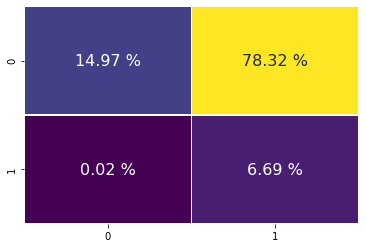


------------------- Threshold 0.42 ------------------



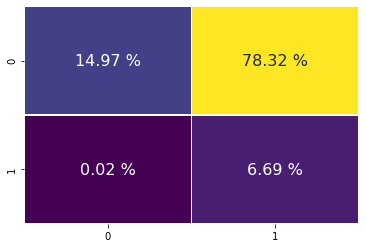


------------------- Threshold 0.43 ------------------



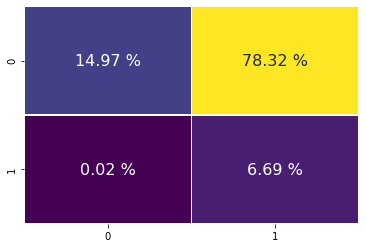


------------------- Threshold 0.44 ------------------



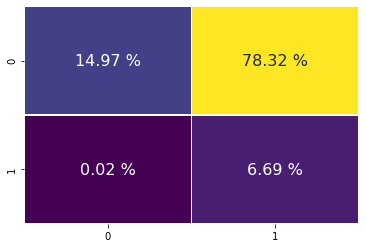


------------------- Threshold 0.45 ------------------



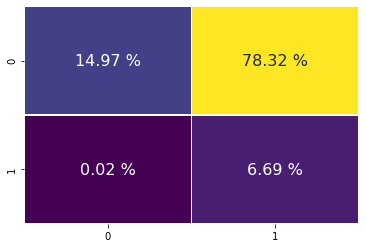

In [21]:
for threshold in [0.41, 0.42, 0.43, 0.44, 0.45]:

    print('\n------------------- Threshold {} ------------------\n'.format(threshold))
    predicted = mRandomForest.predict_proba(dfXValidation)
    predicted = np.where(predicted[:,0] < threshold, 1, 0).astype('int')

    #print((confusion_matrix(dfYValidation, predicted, normalize = 'all') * 100))
    
    dfConfusionMatrix = (confusion_matrix(dfYValidation, predicted, normalize = 'all') * 100)
    
    plotJuly = sns.heatmap(
    dfConfusionMatrix, 
    annot = True,
    annot_kws={"fontsize":16},
    cmap = 'viridis', 
    linewidths = 0.5,
    xticklabels = 1,
    yticklabels = 1,
    cbar = False,
    fmt = '.2f',
    )
    for t in plotJuly.texts: t.set_text(t.get_text() + " %")
    plt.show()
    
    time.sleep(5)

In [6]:
from pandas_profiling import ProfileReport
profile = ProfileReport(dfX, title="Pandas Profiling Report")
profile.to_file("attributes_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 53.53it/s]


In [47]:
#dfReport#[dfReportValidation['index'] == 'recall']
dfReport#[
#    (dfReport['index'] == 'precision')
#]#.sort_values(['1.0', '0.0'], ascending = False).head(10)

Empty DataFrame
Columns: []
Index: []

In [14]:
#dfReportValidation#[dfReportValidation['index'] == 'recall']
dfReportValidation#[(dfReportValidation['model'] == 'has_purchase') & (dfReportValidation['index'].isin(['precision', 'recall']))]

index    0    1  accuracy  auc  counter    model month  depth  \
0  precision 1.00 0.08      0.22 0.42        1  has_buy   aug      2   
1     recall 0.16 1.00      0.22 0.42        1  has_buy   aug      2   
2   f1-score 0.28 0.15      0.22 0.42        1  has_buy   aug      2   

   min_smp_split  n_estimators max_features  importance  weight  sub_sample  \
0              2           100         auto           0    0.95       False   
1              2           100         auto           0    0.95       False   
2              2           100         auto           0    0.95       False   

                              obs  
0  Removendo Outliers por Quartil  
1  Removendo Outliers por Quartil  
2  Removendo Outliers por Quartil

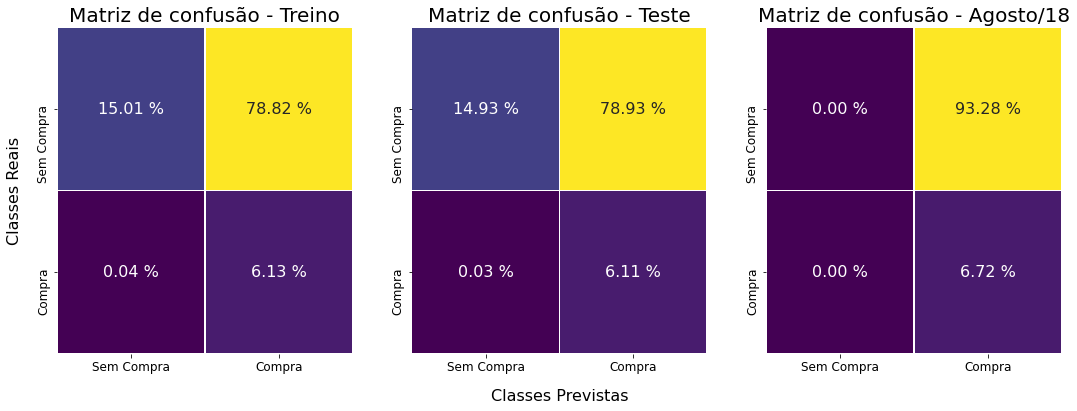

In [105]:
dfConfusionTrain = (confusion_matrix(dfYTrain, mRandomForest.predict(dfXTrain), normalize = 'all') * 100)
dfConfusionTest = (confusion_matrix(dfYTest, mRandomForest.predict(dfXTest), normalize = 'all') * 100)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

iTickFont = 12
iLabelFont = 16
iTitleFont = 20
iLabelPad = 15

plotTrain = sns.heatmap(
    dfConfusionTrain,
    annot_kws={"fontsize":iLabelFont},
    annot = True,
    fmt = '.2f',
    cmap = 'viridis',
    linewidths = 0.5,
    xticklabels = 1,
    yticklabels = 1,
    cbar = False,
    ax = axs[0]
)  #annotTrue to annotate cells, ftm='g' to disable scientific notation
for t in plotTrain.texts: t.set_text(t.get_text() + " %")

# labels, title and ticks
#axs[0].set_xlabel('Classes Previstas',fontsize = iLabelFont, labelpad = iLabelPad)
axs[0].set_ylabel('Classes Reais',fontsize = iLabelFont, labelpad = iLabelPad)
axs[0].set_title('Matriz de confusão - Treino',fontsize = iTitleFont)
axs[0].xaxis.set_ticklabels(['Sem Compra', 'Compra'], fontsize = iTickFont)
axs[0].yaxis.set_ticklabels(['Sem Compra', 'Compra'], fontsize = iTickFont)

plotTest = sns.heatmap(
    dfConfusionTest,
    annot_kws={"fontsize":iLabelFont},
    annot = True,
    fmt = '.2f',
    cmap = 'viridis', 
    linewidths = 0.5,
    xticklabels = 1,
    yticklabels = 1,
    cbar = False,
    ax = axs[1]
)  #annotTrue to annotate cells, ftm='g' to disable scientific notation
for t in plotTest.texts: t.set_text(t.get_text() + " %")

# labels, title and ticks
axs[1].set_xlabel('Classes Previstas',fontsize = iLabelFont, labelpad = iLabelPad)
axs[1].set_title('Matriz de confusão - Teste',fontsize = iTitleFont)
axs[1].xaxis.set_ticklabels(['Sem Compra', 'Compra'], fontsize = iTickFont)
axs[1].set_yticklabels(['Sem Compra', 'Compra'], fontsize = iTickFont)
#ax2.tick_params(axis='both', which='major', pad=15)

dfConfusionMatrix = (confusion_matrix(dfYValidation, mRandomForest.predict(dfXValidation), normalize = 'all') * 100)

plotJuly = sns.heatmap(
    dfConfusionMatrix, 
    annot = True,
    annot_kws={"fontsize":16},
    cmap = 'viridis', 
    linewidths = 0.5,
    xticklabels = 1,
    yticklabels = 1,
    cbar = False,
    fmt = '.2f',
    ax = axs[2]
)
for t in plotJuly.texts: t.set_text(t.get_text() + " %")

# labels, title and ticks
#axs[2].set_xlabel('Classes Previstas', fontsize = iLabelFont, labelpad = iLabelPad)
#axs[2].set_ylabel('Classes Reais', fontsize = iLabelFont, labelpad = iLabelPad)
axs[2].set_title('Matriz de confusão - Agosto/18', fontsize = iTitleFont)
axs[2].set_yticklabels(['Sem Compra', 'Compra'], fontsize = iTickFont)
axs[2].xaxis.set_ticklabels(['Sem Compra', 'Compra'], fontsize = iTickFont)

#plt.savefig(
#    modCommonProj.sModelCouponsPath + 'validation_confusion_estimators{}_maxdepth{}_minsplit{}_weight{}_[{}, {}]_cluster2.png'.format(
#        iNEstimators, iMaxDepth, iMinSampleSplit, iWeight, iMinBuy, iMaxBuy))
#
plt.show()

In [10]:
mRandomForest.feature_importances_


array([1.39935572e-01, 1.00062997e-02, 6.15279583e-05, 3.00119701e-02,
       2.00082574e-02, 1.19943476e-01, 1.19987707e-01, 1.69944658e-01,
       2.04173089e-05, 1.01603600e-04, 4.18333778e-05, 1.22122967e-04,
       1.39952575e-01, 1.09937724e-01, 1.38153107e-05, 1.99910034e-02,
       1.19919438e-01])

### Grafico de Correlacao

In [22]:
dfCorr = dfXTrain.dropna().corr().abs()
mask = np.zeros_like(dfCorr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
dfCorr[mask] = np.nan


In [28]:
dfCorr = dfXTrain.corr().abs()
mask = np.zeros_like(dfCorr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
dfCorr[mask] = np.nan


In [29]:
(dfCorr.style.background_gradient(
    cmap='viridis', axis=None, vmin=0, vmax=1).highlight_null(
        null_color='white').set_precision(2)).set_table_styles(
           [dict(selector="th",props=[('max-width', '400px')]),
            dict(selector="th.col_heading",
                     props=[("writing-mode", "vertical-rl"), 
                            ('transform', 'rotateZ(0deg)'), ('background_color', 'white')
            ]),
            {'selector': 'td', 'props': 'text-align: center; color: white'}
           ]
)

ValueError: not enough values to unpack (expected 2, got 1)

In [24]:
dfCorr.style.background_gradient(
    cmap='viridis', axis=None, vmin=0, vmax=1).highlight_null(
        null_color='white').set_precision(2).set_table_styles(
           [dict(selector="th",props=[('max-width', '400px')]),
            dict(selector="th.col_heading",
                     props=[("writing-mode", "vertical-rl"), 
                            ('transform', 'rotateZ(0deg)'), ('background_color', 'white')
            ]),
            {'selector': 'td', 'props': 'text-align: center; color: white'}
           ]
)

ValueError: not enough values to unpack (expected 2, got 1)

#### Removendo variaveis altamente correlacionadas

In [38]:
importances = mRandomForest.feature_importances_

dfForestImportanceNew = pd.Series(importances, index=dfXTrain.columns).sort_values(ascending = False).to_frame()

#dfCorr = dfXTrain.corr().abs()
dfHighCorr = dfCorr[dfCorr > 0.7].dropna(axis = 0, how = 'all').dropna(axis = 1, how = 'all')

for sCol in dfHighCorr.columns:
    dfSelected = dfHighCorr[~dfHighCorr[sCol].isnull()].index.to_list() + [sCol]
    ssVarSelected = dfForestImportanceNew[dfForestImportanceNew.index.isin(dfSelected)].sort_values(0, ascending = False).index[1:]
    dfForestImportanceNew = dfForestImportanceNew.drop(ssVarSelected, axis = 0)

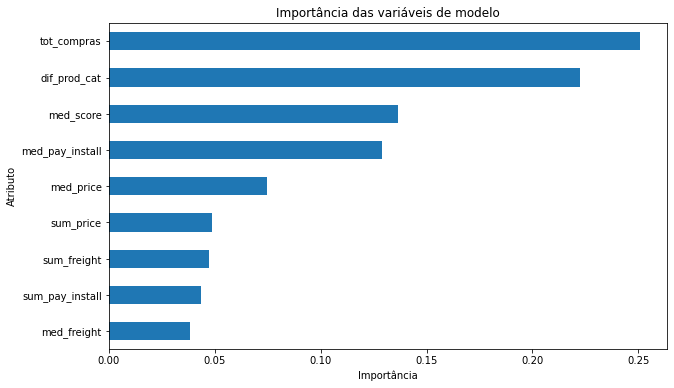

In [44]:
importances = mRandomForest.feature_importances_

dfForestImportanceNew = pd.Series(importances, index=dfXTrain.columns).sort_values(ascending = False).to_frame()

dfForestImportanceNew[dfForestImportanceNew[0] >= 0.01].plot.barh(figsize=(10,6), legend = False)
plt.title('Importância das variáveis de modelo')
plt.xlabel('Importância')
plt.ylabel('Atributo')
plt.gca().invert_yaxis()
plt.show()

In [43]:
dfForestImportanceNew

0
tot_compras     0.25
dif_prod_cat    0.22
med_score       0.14
med_pay_install 0.13
med_price       0.07
sum_price       0.05
sum_freight     0.05
sum_pay_install 0.04
med_freight     0.04
tot_prod        0.01
dif_pay_type    0.00
dif_pay_seq     0.00
dif_seller      0.00
tot_scores      0.00
dif_prod        0.00
tot_pay_seq     0.00
tot_pay_install 0.00